# Lesson: Database-Driven Python

## Introduction

When we connect a Python application, script, or data pipeline to a database, that application becomes more powerful. A RDBMS is networked. That means it can live in a cloud environment, on a public network, or on a private network. Multiple Python applications (or non-Python applications) can connect to that database. Our database is a **single source of truth**. We know data is consistent regardless of which program accesses it.

Python database connectivity turns any Python application into a database client. Its data becomes part of the application. We can seamlessly fetch, create, update, and delete data.

There are two ways to connect Python to a database.

1. **Python Database Drivers**: [PEP 249 – Python Database API Specification v2.0](https://peps.python.org/pep-0249/) recommends a consistent API. It's not part of the standard library. Must be matched with a vendor-specific library. e.g. MySQL, PostgreSQL, Oracle, Microsoft SQL Server, etc.

2. **Object-relational Mapping**, **ORM**: Open-source libraries that have an opinionated approach to modeling Python classes. Examples include [SQLAlchemy](https://www.sqlalchemy.org/), [Pony](https://ponyorm.org/), and [peewee](https://docs.peewee-orm.com/en/latest/). ORM libraries can be very productive and generate SQL automatically. Unfortunately, they also have a steep learning curve.

### Learning Outcomes

When you've finished this lesson and its exercises, you should be able to:

- Describe the problem a **Connection** solves.
- Use **Cursor** methods.
- Identify a scenario where SQL injection could occur.
- Provide two ORM advantages and disadvantages.

## Background

Database management systems are networked. That's one of their most powerful features. If a client sends a valid network request, it can expect a valid response. Once the server is on the network, it doesn't care about any particular application or programming language. Instead, it listens for requests, executes valid requests, and returns results. Any application or programming language that knows the rules may work with the database.

The rules of networked database requests and responses are defined by a **protocol**. A protocol specifies which bytes are allowed in which order (syntax) and what those bytes mean (semantics). Database protocols strike a balance between speed and size efficiency. It's important for requests to execute quickly so the server can handle many requests. But data should also be transmitted with as few bytes as possible to reduce bandwidth. These goals conflict. Size reduction (data compression) takes time.

All major database systems: MySQL, PostgreSQL, Oracle, MS SQL Server, etc, use proprietary protocols. There is no standard database protocol. Vendor protocols are elaborate and may contain trade secrets. Luckily, we don't have to write code that manipulates the protocol bits and bytes directly. Instead, vendor developers who know their protocols create libraries called **drivers**.

A database driver manages database requests and responses and adds a layer of abstraction on top of the protocol. It introduces concepts like:

<dl>
<dt>Connection</dt>
<dd>An open network channel between client and server used to send SQL and receive data or statuses.</dd>
<dt>Cursor</dt>
<dd>An object that selects, inserts, updates, and deletes (CRUD).</dd>
<dt>Iterator</dt>
<dd>Data returned from a read request. Usually organized in a row-based or table-based format.</dd>
</dl>

Unfortunately, like database protocols, database drivers also lack a standard. Their general concepts are the same -- connection, cursor, iterator -- but every driver gives those concepts slightly different names and handles them differently.

## PEP 249

The Python Database API Specification v2.0 was first created in Apr 12, 1999. The community realized changing between database vendors would be cumbersome and error-prone given the differences between drivers. A vendor change would require all database code to be rewritten. They also realized that the underlying concepts were common and universal.

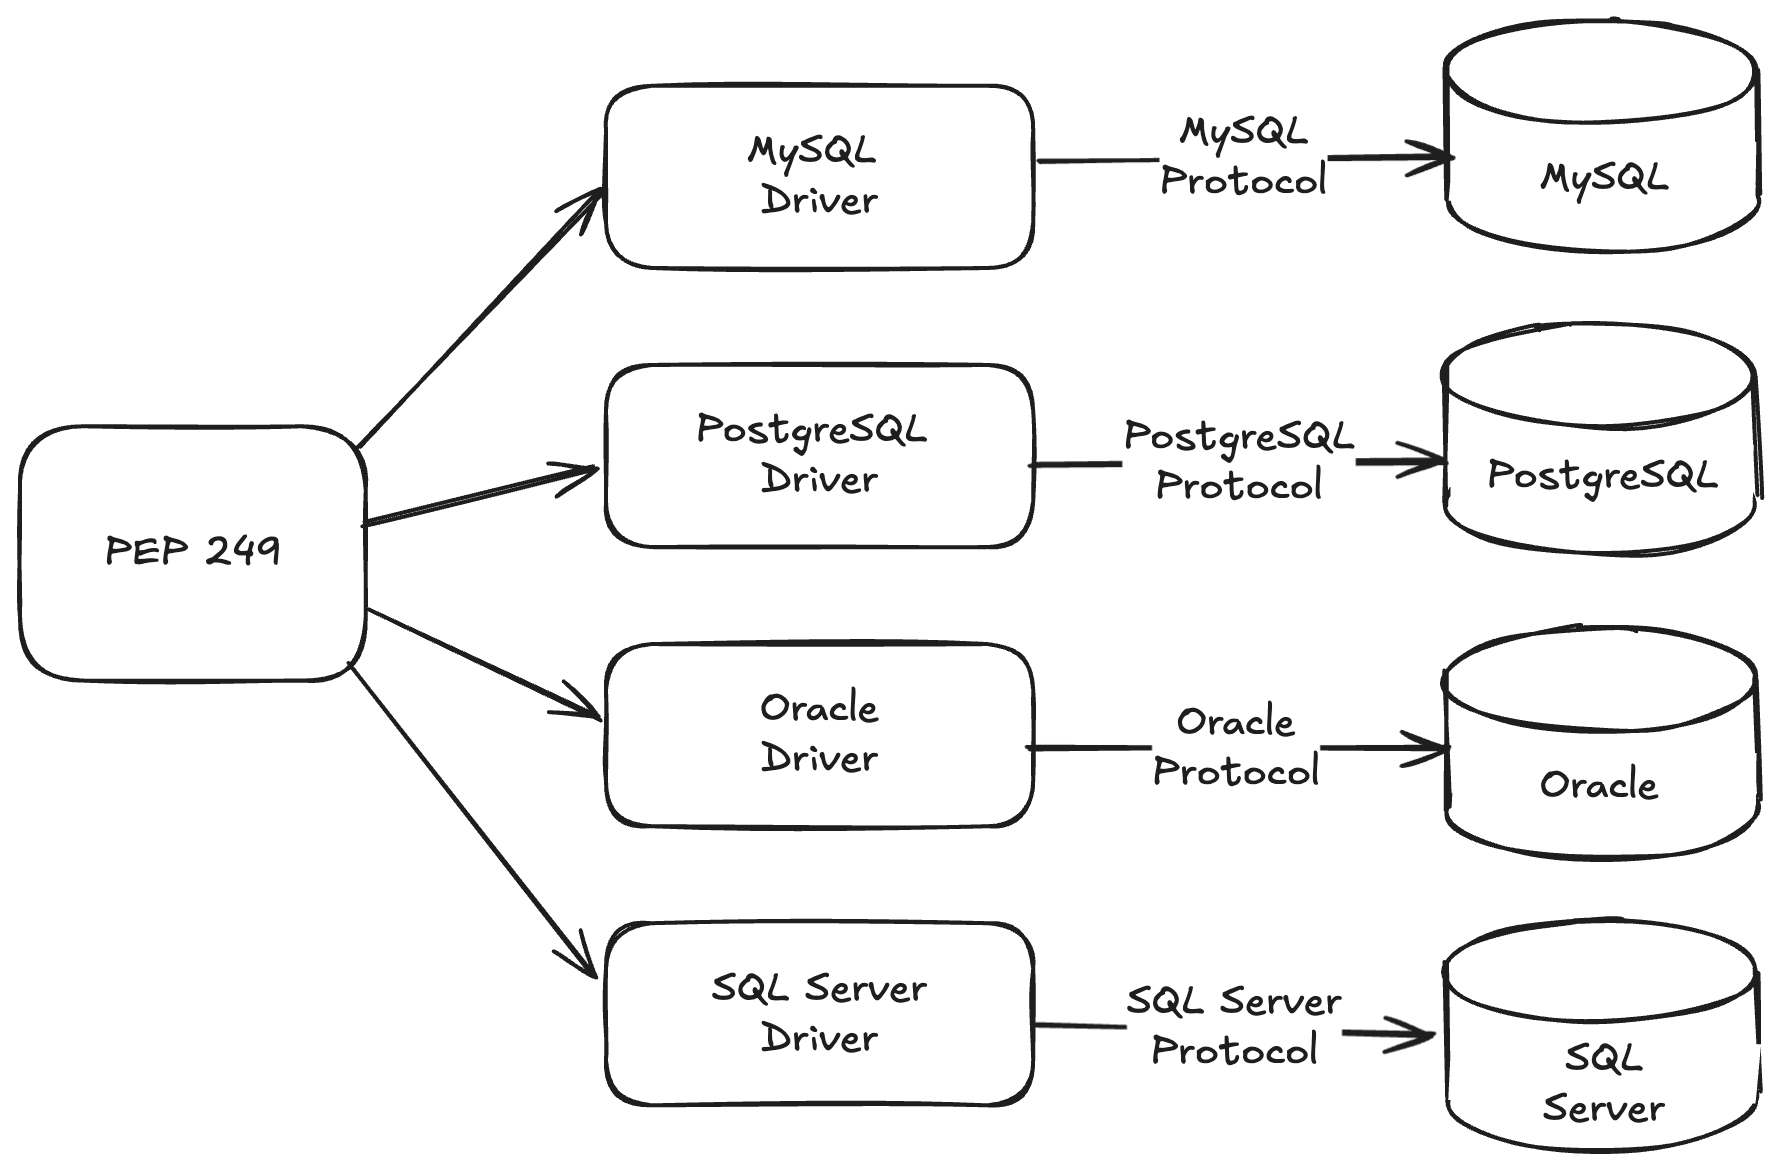

<blockquote style="padding: 1.5rem;">
If PEP 249 was never created and it was common for your project to switch database vendors, how would you reduce the risk of change?
</blockquote>

Before we talk about universal interfaces and classes, we should talk about database connections. A **database connection** is a two-way communication channel between a client (a Python script, MySQL Workbench) and a database server. Once a connection is established, the client can send SQL statements to the server and receive results as tabular data (`select`) or rows affected (`insert`, `update`, and `delete`). There's a cost to establishing a database connection. The server must confirm the client is authorized to connect. For that reason, it makes sense to open a database connection and keep it open so each new statement doesn't incur the new connection cost.

Database connections are limited depending on server resources. A database server can only track a finite number of network connections.

## `bowls`

We'll use the `bowls` schema.

The `bowls` schema powers the (fictional) Bowls restaurant in Milwaukee. Bowls sells delicious food served in a bowl. It offers delivery and curbside pickup. It tracks its customers, menu items, and customer orders in a database. Some customers have opted-in to online ordering. If they have, they have a `login` record.

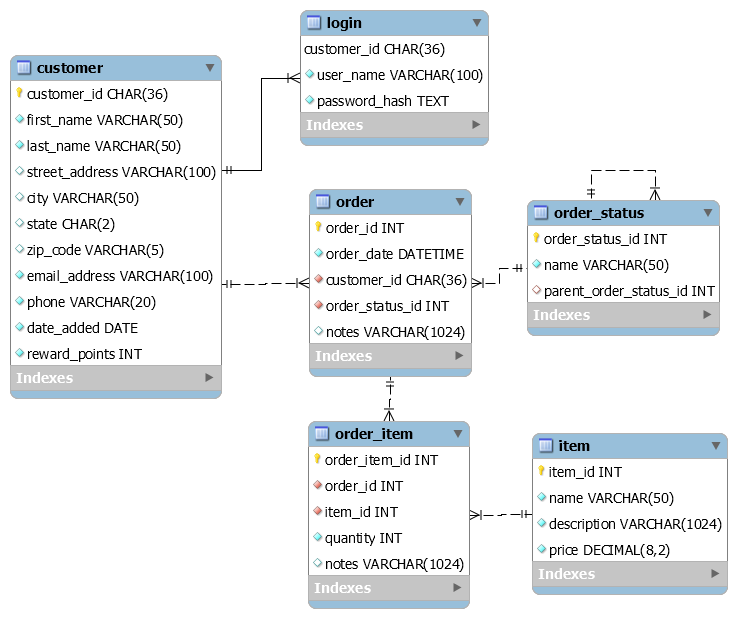

## Connection

A connection object _connects_ to a database with credentials. It requires a host (URL), port (defaults to 3306), a username, a password, and a database name. It's methods are `close`, `commit`, `rollback`, and `cursor`.

In [1]:
import mysql.connector

# Change your local MySQL credentials
db_username = "root"
db_password = "bug4pig"

cnx = mysql.connector.connect(
    host="localhost", port=3306, user=db_username, password=db_password, database="bowls"
)

print(cnx.connection_id)
print(cnx.is_connected())
cnx.close()

173
True


> Never store a password in plain text in either code or a configuration file, especially in a public repository. Each time you push a file to a public Github repository, an army of bots scans your push for credentials. If the credentials are for a public resource, you're doomed.

## Cursor

A cursor object is extremely flexible. It supports SQL CRUD commands.

- INSERT (Create)
- SELECT (Read)
- UPDATE (Update)
- DELETE (Delete)

It uses the `execute` method to fetch, insert, update, and delete records. It can also use stored procedures.

In [2]:
cnx = mysql.connector.connect(
    host="localhost",
    port=3306,
    user=db_username,
    password=db_password,
    database="bowls",
)

cursor = cnx.cursor()
cursor.execute("SELECT * FROM customer LIMIT 15;")

record = cursor.fetchone()
print("First record:")
print(record)

print("2-4 records:")
for record in cursor.fetchmany(size=3):
    print(record)

print("All but first 4 records:")
records = cursor.fetchall()
for record in records:
    print(record)

print("\nItems")
cursor.execute("SELECT * FROM item;")
for record in cursor:
    print(record)

cursor.close()
cnx.close()


First record:
('0035918a-ce8e-41b2-8811-d0c20e4d5aec', 'Em', 'Cockill', '74 Leroy Trail', 'Cudahy', 'WI', '53110', 'ecockillfd@ehow.com', '(735) 1169206', datetime.date(2018, 5, 13), 0)
2-4 records:
('00517372-d165-42cf-a70c-1e5e9abd3957', 'Jecho', 'Burkert', '04 Carpenter Alley', 'Cudahy', 'WI', '53110', 'jburkerto0@senate.gov', '(571) 4438578', datetime.date(2019, 2, 27), 461)
('0055c22b-ba9e-449b-935b-bc428873e013', 'Egbert', 'Coneybeer', '2 Warbler Alley', 'South Milwaukee', 'WI', '53154', 'econeybeerqb@booking.com', '(951) 2462185', datetime.date(2018, 11, 23), 244)
('0058d437-3ae2-47b8-8beb-8e62dc0bc346', 'Kingston', 'Shortt', None, None, None, None, 'kshortt78@facebook.com', '(916) 5462525', datetime.date(2018, 12, 30), 0)
All but first 4 records:
('008a860a-c667-4135-98b6-5968ac350c7a', 'Mella', 'Ianetti', '6337 Coleman Terrace', 'Shorewood', 'WI', '53211', 'mianetti7i@virginia.edu', '(917) 5770497', datetime.date(2020, 3, 12), 368)
('008ee446-cf88-4e17-9d16-d72fe381e813', 'Aur

Our fetch methods: `fetchone`, `fetchmany`, `fetchall`, produce a sequence of tuples and can auto-translate SQL data types (`decimal(8,2)`, `date`) to Python data types (`datetime.date`, `Decimal`).

### Aside: SQL Injection

A SQL injection attack can occur when a developer builds a SQL statement with string concatenation and doesn't ensure a dynamic parameter is SQL-free. Never use string concatenation for SQL.

Consider:

---

```py
import mysql.connector

cnx = mysql.connector.connect(host="localhost")
cursor = cnx.cursor()

first_name = input("Enter a name: ")

sql = "SELECT * FROM customer WHERE first_name = '" + first_name + "';"

for record in cursor.execute(sql):
    print(record)
```

---

If the `first_name` argument isn't SQL-free, consider how it could be used to adjust the query.

| `first_name` | `sql` | Outcome |
| --- | --- | --- |
| `Trudy` | `select * from customer where first_name = 'Trudy';` | Okay |
| `'; DROP TABLE user;--` | `select * from customer where first_name = ''; DROP TABLE user;--';` | Depending on permissions and statement configuration, may delete a whole table. |
| `' union select 0, user_name 'first_name', password_hash 'last_name' from user where role = 'admin` | `select * from customer where first_name = '' union select 0, user_name 'first_name', password_hash 'last_name' from user where role = 'admin';` | Merges data from the user and customer table. |

Not all SQL statements are vulnerable to injection. We should use parameterized queries to ensure SQL arguments don't get into our SQL statements. The `mysql-connector-python` package automatically sanitizes our SQL to represent it as a string.

---

```py
cnx = mysql.connector.connect(host="localhost")
cursor = cnx.cursor()

first_name = input("Enter a name: ")

sql = "SELECT * FROM customer WHERE first_name = %s;"

cursor.execute(sql, (first_name,))

for record in cursor:
    print(record)
```

---

## Connection Pool

A **connection pool** is a collection of connections with a connection count threshold. A connection pool is zero or more open connections available for use. `mysql-connector-python` has connection pool support as well as other Python database drivers. 

When we `close()` our our connection, we don't really "close" it. The connection remains in the pool, tracking two-way communication to our database and Python application. When we instantiate a connection, `cnx = mysql.connector.connect(**credentials)`, and the credentialed connection exists in the pool, we just use an existing connection.

Database connections are _expensive_. Connection pools have two benefits: 1. It cuts down on the overhead of creating new connections and 2. It reduces the total number of connections. Methods can efficiently reuse available open connections.

Our `mysql-connector-python` package hides the details from us, but we can also explicitly manage a connection pool:

[pooling.MySQLConnectionPool Constructor](https://dev.mysql.com/doc/connector-python/en/connector-python-api-mysqlconnectionpool-constructor.html)

## ORM Libraries

ORM (object-relational mapping) is a software development technique used to map objects in an object-oriented programming language to relational database tables.

ORM libraries are fairly complex. Again, complexity meaning engineering complexity and a steep learning curve.

Many teams are torn about ORM technology, but most use them. Here are some advantages and disadvantages:

**Advantages**

1. **Productivity**: ORM simplifies database interactions by abstracting away the complex SQL queries and providing high-level tools. Developers can focus on the application's logic rather than writing and optimizing SQL queries.

2. **Portability**: ORM libraries allow developers to switch between different database systems (MySQL, PostgreSQL, Oracle, MS SQL Server) without changing the application's codebase.

3. **Maintainability**: With ORM, developers can define database schemas and relationships using code annotations or configuration files. Changes in database structure are reflected in a central location. This helps maintain a clean and consistent codebase.

4. **Object-orientation**: Allows developers to work with databases using familiar object-oriented concepts. This makes it easier to understand the codebase, especially for developers with a background in object-oriented programming.

5. **Performance optimizations**: ORM libraries provide performance optimizations, such as caching, lazy loading, and query tuning. These optimizations enhance the application's performance by reducing the number of database queries and enhancing retrieval strategies.

**Disadvantages**

1. **Learning curve**: While ORM simplifies database interaction, it introduces its own learning curve. Developers must understand the ORM library concepts, configuration, and limitations. What's worse, complex queries may require writing custom SQL, which demands knowledge of both the ORM and SQL.

2. **Performance**: ORM libraries may introduce performance overhead compared to writing raw SQL queries. The ORM layer translates high-level object-oriented operations into SQL statements. They may not be as efficient as hand-tuned SQL queries. However, modern ORM libraries have improved performance significantly.

3. **Database-specific features**: ORM libraries cannot access proprietary SQL or proprietary database features.

4. **Query complexity**: While ORM libraries excel at simple CRUD operations, complex queries involving joins, aggregations, or sub-queries can be challenging to express using the ORM's tooling. In these cases, writing custom SQL might be necessary, which can bypass some of the ORM's benefits.

5. **Debugging and troubleshooting**: When performance bottlenecks or unexpected behavior arise, ORM-related problems can be more complex to debug than raw SQL. The abstraction between application code and the database makes it harder to trace generated SQL and its execution.